In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
data = pd.HDFStore('store.h5')['df']

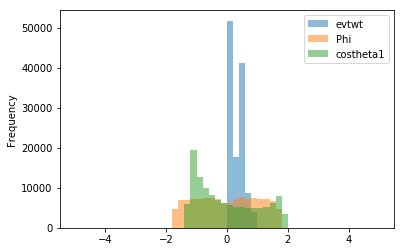

In [2]:
data['evtwt'].plot.hist(range=(-5,5), bins=50, label='evtwt', alpha=0.5)
data['Phi'].plot.hist(range=(-5,5), bins=50, label='Phi', alpha=0.5)
data['costheta1'].plot.hist(range=(-5,5), bins=50, label='costheta1', alpha=0.5)
plt.legend()

In [3]:
sample_groups = data.groupby('sample_names')

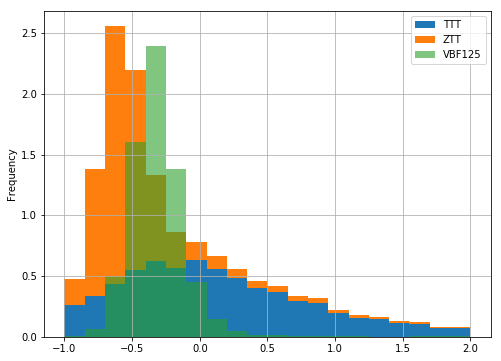

In [4]:
fig, ax = plt.subplots()
pd.DataFrame({'ZTT': sample_groups.get_group('ZTT.root').m_sv,
              'TTT':   sample_groups.get_group('TTT.root').m_sv}).plot.hist(
    stacked=True, ax=ax, range=(-1,2), bins=20, density=True
)
sample_groups.get_group('VBF125.root').m_sv.hist(label='VBF125', ax=ax, alpha=0.6, linewidth=3, bins=20, range=(-1,2), density=True, figsize=(8,6))
ax.legend()

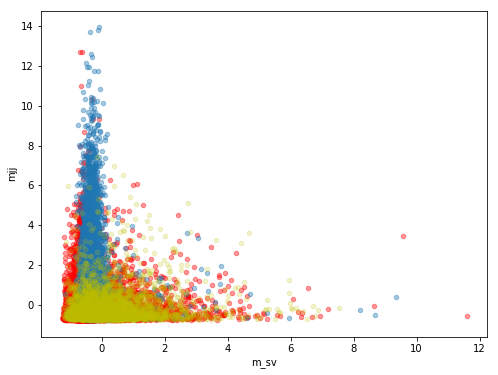

In [5]:
fig2, ax2 = plt.subplots()
sample_groups.get_group('ZTT.root').plot.scatter(
    'm_sv', 'mjj', ax=ax2, color='r', marker='o', alpha=0.4
)
sample_groups.get_group('VBF125.root').plot.scatter(
    'm_sv', 'mjj', ax=ax2, alpha=0.4, marker='o', figsize=(8,6)
)
sample_groups.get_group('TTT.root').plot.scatter(
    'm_sv', 'mjj', ax=ax2, color='y', alpha=0.2, marker='o', figsize=(8,6)
)

In [6]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [7]:
model = Sequential()
model.add(Dense(7, input_shape=(7,), name='input', activation='sigmoid'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 7)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [8]:
## build callbacks
callbacks = [
            EarlyStopping(monitor='val_loss', patience=50),
            ModelCheckpoint('unweighted_test.hdf5', monitor='val_loss',
                            verbose=0, save_best_only=True,
                            save_weights_only=False, mode='auto',
                            period=1
                            )
        ]

In [9]:
## get the data for the two-classes to discriminate
training_processes = data[(data['sample_names'] == 'ZTT.root') | (data['sample_names'] == 'VBF125.root')]

In [10]:
## do event selection
selected_events = training_processes[
    (training_processes['el_iso'] < 0.1) & \
    (training_processes['t1_tightIso'] > 0) & \
    (training_processes['nbjets'] == 0) & \
    (training_processes['el_charge'] + training_processes['t1_charge'] == 0)
]

In [11]:
training_dataframe = selected_events[
    ['Q2V1', 'Q2V2', 'Phi', 'Phi1', 'costheta1', 'costheta2', 'costhetastar', 'isSignal', 'evtwt']
]

In [12]:
from sklearn.model_selection import train_test_split

training_data, testing_data, training_meta, testing_meta = train_test_split(
    training_dataframe.values[:, :7], training_dataframe.values[:,7:], test_size=0.1, random_state=7
)

In [13]:
training_labels = training_meta[:,0]
training_weights = training_meta[:,1]
print training_weights

[0.20549594 0.06344468 0.58823383 ... 0.11105495 0.06807902 0.68742144]


In [14]:
## train that there model, my dude
history = model.fit(training_data, training_labels, shuffle=True,
                      epochs=10000, batch_size=1024, verbose=True,
                      callbacks=callbacks, validation_split=0.25
                      )

Train on 10251 samples, validate on 3418 samples
Epoch 1/10000
10251/10251 [==============================] - 0s 24us/step - loss: 0.6950 - acc: 0.4673 - val_loss: 0.6873 - val_acc: 0.6235
Epoch 2/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.6827 - acc: 0.6851 - val_loss: 0.6750 - val_acc: 0.7589
Epoch 3/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.6711 - acc: 0.7529 - val_loss: 0.6636 - val_acc: 0.7627
Epoch 4/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.6606 - acc: 0.7536 - val_loss: 0.6533 - val_acc: 0.7627
Epoch 5/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.6508 - acc: 0.7536 - val_loss: 0.6434 - val_acc: 0.7627
Epoch 6/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.6417 - acc: 0.7536 - val_loss: 0.6344 - val_acc: 0.7627
Epoch 7/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.6334 - acc: 0.7536 - val_loss: 0.

10251/10251 [==============================] - 0s 2us/step - loss: 0.5361 - acc: 0.7536 - val_loss: 0.5254 - val_acc: 0.7627
Epoch 60/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5357 - acc: 0.7536 - val_loss: 0.5251 - val_acc: 0.7627
Epoch 61/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5353 - acc: 0.7536 - val_loss: 0.5248 - val_acc: 0.7627
Epoch 62/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5350 - acc: 0.7536 - val_loss: 0.5245 - val_acc: 0.7627
Epoch 63/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5347 - acc: 0.7536 - val_loss: 0.5241 - val_acc: 0.7627
Epoch 64/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5344 - acc: 0.7536 - val_loss: 0.5240 - val_acc: 0.7627
Epoch 65/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5341 - acc: 0.7536 - val_loss: 0.5236 - val_acc: 0.7627
Epoch 66/10000
10251/10251 [=======

10251/10251 [==============================] - 0s 2us/step - loss: 0.5213 - acc: 0.7536 - val_loss: 0.5110 - val_acc: 0.7627
Epoch 118/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5211 - acc: 0.7536 - val_loss: 0.5108 - val_acc: 0.7627
Epoch 119/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5209 - acc: 0.7536 - val_loss: 0.5106 - val_acc: 0.7627
Epoch 120/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5207 - acc: 0.7536 - val_loss: 0.5104 - val_acc: 0.7627
Epoch 121/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5205 - acc: 0.7536 - val_loss: 0.5103 - val_acc: 0.7627
Epoch 122/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5203 - acc: 0.7536 - val_loss: 0.5101 - val_acc: 0.7627
Epoch 123/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5201 - acc: 0.7536 - val_loss: 0.5099 - val_acc: 0.7627
Epoch 124/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.5126 - acc: 0.7536 - val_loss: 0.5026 - val_acc: 0.7627
Epoch 176/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5125 - acc: 0.7536 - val_loss: 0.5024 - val_acc: 0.7627
Epoch 177/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5123 - acc: 0.7536 - val_loss: 0.5023 - val_acc: 0.7627
Epoch 178/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5121 - acc: 0.7536 - val_loss: 0.5023 - val_acc: 0.7627
Epoch 179/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5120 - acc: 0.7536 - val_loss: 0.5022 - val_acc: 0.7627
Epoch 180/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5118 - acc: 0.7536 - val_loss: 0.5021 - val_acc: 0.7627
Epoch 181/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5117 - acc: 0.7536 - val_loss: 0.5020 - val_acc: 0.7627
Epoch 182/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.5053 - acc: 0.7536 - val_loss: 0.4963 - val_acc: 0.7627
Epoch 234/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5052 - acc: 0.7536 - val_loss: 0.4961 - val_acc: 0.7627
Epoch 235/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5052 - acc: 0.7536 - val_loss: 0.4960 - val_acc: 0.7627
Epoch 236/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5050 - acc: 0.7536 - val_loss: 0.4959 - val_acc: 0.7627
Epoch 237/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5049 - acc: 0.7536 - val_loss: 0.4959 - val_acc: 0.7627
Epoch 238/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5048 - acc: 0.7536 - val_loss: 0.4960 - val_acc: 0.7627
Epoch 239/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5048 - acc: 0.7536 - val_loss: 0.4962 - val_acc: 0.7627
Epoch 240/10000
10251/10251 [

Epoch 291/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5002 - acc: 0.7536 - val_loss: 0.4916 - val_acc: 0.7627
Epoch 292/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5001 - acc: 0.7536 - val_loss: 0.4916 - val_acc: 0.7627
Epoch 293/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5000 - acc: 0.7536 - val_loss: 0.4914 - val_acc: 0.7627
Epoch 294/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.5000 - acc: 0.7536 - val_loss: 0.4913 - val_acc: 0.7627
Epoch 295/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4999 - acc: 0.7536 - val_loss: 0.4912 - val_acc: 0.7627
Epoch 296/10000
10251/10251 [==============================] - 0s 1us/step - loss: 0.4998 - acc: 0.7536 - val_loss: 0.4910 - val_acc: 0.7627
Epoch 297/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4997 - acc: 0.7536 - val_loss: 0.4909 - val_acc: 0.7627
Epoch 298/100

10251/10251 [==============================] - 0s 2us/step - loss: 0.4961 - acc: 0.7525 - val_loss: 0.4875 - val_acc: 0.7616
Epoch 350/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4960 - acc: 0.7523 - val_loss: 0.4873 - val_acc: 0.7616
Epoch 351/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4959 - acc: 0.7525 - val_loss: 0.4872 - val_acc: 0.7621
Epoch 352/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4959 - acc: 0.7531 - val_loss: 0.4870 - val_acc: 0.7627
Epoch 353/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4958 - acc: 0.7533 - val_loss: 0.4869 - val_acc: 0.7627
Epoch 354/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4958 - acc: 0.7535 - val_loss: 0.4867 - val_acc: 0.7627
Epoch 355/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4957 - acc: 0.7535 - val_loss: 0.4866 - val_acc: 0.7627
Epoch 356/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.4929 - acc: 0.7476 - val_loss: 0.4842 - val_acc: 0.7554
Epoch 408/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4928 - acc: 0.7470 - val_loss: 0.4842 - val_acc: 0.7545
Epoch 409/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4928 - acc: 0.7468 - val_loss: 0.4842 - val_acc: 0.7545
Epoch 410/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4927 - acc: 0.7469 - val_loss: 0.4841 - val_acc: 0.7545
Epoch 411/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4927 - acc: 0.7469 - val_loss: 0.4841 - val_acc: 0.7545
Epoch 412/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4926 - acc: 0.7467 - val_loss: 0.4841 - val_acc: 0.7542
Epoch 413/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4926 - acc: 0.7465 - val_loss: 0.4842 - val_acc: 0.7542
Epoch 414/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.4899 - acc: 0.7466 - val_loss: 0.4815 - val_acc: 0.7525
Epoch 466/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4898 - acc: 0.7461 - val_loss: 0.4815 - val_acc: 0.7525
Epoch 467/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4898 - acc: 0.7462 - val_loss: 0.4815 - val_acc: 0.7525
Epoch 468/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4898 - acc: 0.7454 - val_loss: 0.4817 - val_acc: 0.7513
Epoch 469/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4898 - acc: 0.7446 - val_loss: 0.4816 - val_acc: 0.7507
Epoch 470/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4897 - acc: 0.7448 - val_loss: 0.4815 - val_acc: 0.7513
Epoch 471/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4896 - acc: 0.7458 - val_loss: 0.4812 - val_acc: 0.7537
Epoch 472/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.4868 - acc: 0.7485 - val_loss: 0.4781 - val_acc: 0.7595
Epoch 524/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4867 - acc: 0.7486 - val_loss: 0.4781 - val_acc: 0.7595
Epoch 525/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4866 - acc: 0.7488 - val_loss: 0.4780 - val_acc: 0.7595
Epoch 526/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4866 - acc: 0.7490 - val_loss: 0.4779 - val_acc: 0.7598
Epoch 527/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4865 - acc: 0.7491 - val_loss: 0.4779 - val_acc: 0.7598
Epoch 528/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4864 - acc: 0.7491 - val_loss: 0.4778 - val_acc: 0.7598
Epoch 529/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4864 - acc: 0.7489 - val_loss: 0.4778 - val_acc: 0.7592
Epoch 530/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.4832 - acc: 0.7474 - val_loss: 0.4749 - val_acc: 0.7566
Epoch 582/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4831 - acc: 0.7472 - val_loss: 0.4748 - val_acc: 0.7566
Epoch 583/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4830 - acc: 0.7472 - val_loss: 0.4747 - val_acc: 0.7560
Epoch 584/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4830 - acc: 0.7473 - val_loss: 0.4747 - val_acc: 0.7563
Epoch 585/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4829 - acc: 0.7474 - val_loss: 0.4747 - val_acc: 0.7548
Epoch 586/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4828 - acc: 0.7471 - val_loss: 0.4748 - val_acc: 0.7545
Epoch 587/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4828 - acc: 0.7465 - val_loss: 0.4748 - val_acc: 0.7545
Epoch 588/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.4792 - acc: 0.7482 - val_loss: 0.4712 - val_acc: 0.7583
Epoch 640/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4791 - acc: 0.7484 - val_loss: 0.4712 - val_acc: 0.7580
Epoch 641/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4790 - acc: 0.7483 - val_loss: 0.4711 - val_acc: 0.7580
Epoch 642/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4790 - acc: 0.7484 - val_loss: 0.4711 - val_acc: 0.7580
Epoch 643/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4789 - acc: 0.7486 - val_loss: 0.4710 - val_acc: 0.7583
Epoch 644/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4789 - acc: 0.7488 - val_loss: 0.4709 - val_acc: 0.7583
Epoch 645/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4788 - acc: 0.7489 - val_loss: 0.4708 - val_acc: 0.7586
Epoch 646/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.4746 - acc: 0.7479 - val_loss: 0.4671 - val_acc: 0.7545
Epoch 698/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4745 - acc: 0.7477 - val_loss: 0.4671 - val_acc: 0.7539
Epoch 699/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4745 - acc: 0.7474 - val_loss: 0.4671 - val_acc: 0.7551
Epoch 700/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4744 - acc: 0.7475 - val_loss: 0.4672 - val_acc: 0.7545
Epoch 701/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4743 - acc: 0.7471 - val_loss: 0.4674 - val_acc: 0.7545
Epoch 702/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4743 - acc: 0.7471 - val_loss: 0.4674 - val_acc: 0.7548
Epoch 703/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4742 - acc: 0.7474 - val_loss: 0.4672 - val_acc: 0.7551
Epoch 704/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.4696 - acc: 0.7493 - val_loss: 0.4630 - val_acc: 0.7545
Epoch 756/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4695 - acc: 0.7496 - val_loss: 0.4628 - val_acc: 0.7560
Epoch 757/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4694 - acc: 0.7500 - val_loss: 0.4627 - val_acc: 0.7569
Epoch 758/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4693 - acc: 0.7494 - val_loss: 0.4625 - val_acc: 0.7580
Epoch 759/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4692 - acc: 0.7495 - val_loss: 0.4623 - val_acc: 0.7592
Epoch 760/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4691 - acc: 0.7494 - val_loss: 0.4622 - val_acc: 0.7595
Epoch 761/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4690 - acc: 0.7493 - val_loss: 0.4621 - val_acc: 0.7589
Epoch 762/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.4635 - acc: 0.7520 - val_loss: 0.4569 - val_acc: 0.7586
Epoch 814/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4633 - acc: 0.7518 - val_loss: 0.4568 - val_acc: 0.7589
Epoch 815/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4632 - acc: 0.7521 - val_loss: 0.4567 - val_acc: 0.7586
Epoch 816/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4631 - acc: 0.7526 - val_loss: 0.4566 - val_acc: 0.7598
Epoch 817/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4630 - acc: 0.7526 - val_loss: 0.4565 - val_acc: 0.7598
Epoch 818/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4630 - acc: 0.7528 - val_loss: 0.4564 - val_acc: 0.7598
Epoch 819/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4628 - acc: 0.7529 - val_loss: 0.4563 - val_acc: 0.7601
Epoch 820/10000
10251/10251 [

10251/10251 [==============================] - 0s 2us/step - loss: 0.4560 - acc: 0.7559 - val_loss: 0.4501 - val_acc: 0.7642
Epoch 872/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4558 - acc: 0.7560 - val_loss: 0.4501 - val_acc: 0.7648
Epoch 873/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4557 - acc: 0.7558 - val_loss: 0.4499 - val_acc: 0.7645
Epoch 874/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4556 - acc: 0.7550 - val_loss: 0.4497 - val_acc: 0.7645
Epoch 875/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4555 - acc: 0.7549 - val_loss: 0.4496 - val_acc: 0.7651
Epoch 876/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4553 - acc: 0.7550 - val_loss: 0.4494 - val_acc: 0.7651
Epoch 877/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4552 - acc: 0.7557 - val_loss: 0.4493 - val_acc: 0.7648
Epoch 878/10000
10251/10251 [

Epoch 929/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7681 - val_loss: 0.4430 - val_acc: 0.7747
Epoch 930/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4479 - acc: 0.7688 - val_loss: 0.4430 - val_acc: 0.7759
Epoch 931/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7709 - val_loss: 0.4430 - val_acc: 0.7774
Epoch 932/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4477 - acc: 0.7722 - val_loss: 0.4429 - val_acc: 0.7797
Epoch 933/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4476 - acc: 0.7725 - val_loss: 0.4427 - val_acc: 0.7782
Epoch 934/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4474 - acc: 0.7715 - val_loss: 0.4424 - val_acc: 0.7768
Epoch 935/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7697 - val_loss: 0.4421 - val_acc: 0.7753
Epoch 936/100

10251/10251 [==============================] - 0s 2us/step - loss: 0.4404 - acc: 0.7835 - val_loss: 0.4356 - val_acc: 0.7911
Epoch 988/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4402 - acc: 0.7829 - val_loss: 0.4352 - val_acc: 0.7882
Epoch 989/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4401 - acc: 0.7807 - val_loss: 0.4350 - val_acc: 0.7876
Epoch 990/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4400 - acc: 0.7803 - val_loss: 0.4349 - val_acc: 0.7876
Epoch 991/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4399 - acc: 0.7800 - val_loss: 0.4347 - val_acc: 0.7873
Epoch 992/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4398 - acc: 0.7788 - val_loss: 0.4346 - val_acc: 0.7864
Epoch 993/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4398 - acc: 0.7784 - val_loss: 0.4345 - val_acc: 0.7864
Epoch 994/10000
10251/10251 [

Epoch 1045/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4338 - acc: 0.7843 - val_loss: 0.4287 - val_acc: 0.7917
Epoch 1046/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4337 - acc: 0.7838 - val_loss: 0.4286 - val_acc: 0.7934
Epoch 1047/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4335 - acc: 0.7858 - val_loss: 0.4285 - val_acc: 0.7952
Epoch 1048/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4333 - acc: 0.7873 - val_loss: 0.4284 - val_acc: 0.7975
Epoch 1049/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4331 - acc: 0.7883 - val_loss: 0.4283 - val_acc: 0.7978
Epoch 1050/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4330 - acc: 0.7897 - val_loss: 0.4284 - val_acc: 0.8040
Epoch 1051/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4329 - acc: 0.7924 - val_loss: 0.4283 - val_acc: 0.8046
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.4273 - acc: 0.7973 - val_loss: 0.4230 - val_acc: 0.8069
Epoch 1103/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4272 - acc: 0.7986 - val_loss: 0.4229 - val_acc: 0.8078
Epoch 1104/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4271 - acc: 0.7976 - val_loss: 0.4228 - val_acc: 0.8069
Epoch 1105/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4270 - acc: 0.7984 - val_loss: 0.4227 - val_acc: 0.8084
Epoch 1106/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4269 - acc: 0.7995 - val_loss: 0.4227 - val_acc: 0.8087
Epoch 1107/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4268 - acc: 0.8001 - val_loss: 0.4225 - val_acc: 0.8078
Epoch 1108/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4267 - acc: 0.8000 - val_loss: 0.4224 - val_acc: 0.8078
Epoch 1109/10000
10251/

Epoch 1160/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4216 - acc: 0.8070 - val_loss: 0.4173 - val_acc: 0.8166
Epoch 1161/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4215 - acc: 0.8064 - val_loss: 0.4171 - val_acc: 0.8166
Epoch 1162/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4214 - acc: 0.8062 - val_loss: 0.4170 - val_acc: 0.8154
Epoch 1163/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4213 - acc: 0.8048 - val_loss: 0.4169 - val_acc: 0.8139
Epoch 1164/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4212 - acc: 0.8028 - val_loss: 0.4168 - val_acc: 0.8136
Epoch 1165/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4211 - acc: 0.8033 - val_loss: 0.4168 - val_acc: 0.8157
Epoch 1166/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4210 - acc: 0.8062 - val_loss: 0.4168 - val_acc: 0.8157
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.4162 - acc: 0.8089 - val_loss: 0.4120 - val_acc: 0.8180
Epoch 1218/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4161 - acc: 0.8087 - val_loss: 0.4120 - val_acc: 0.8189
Epoch 1219/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4160 - acc: 0.8103 - val_loss: 0.4119 - val_acc: 0.8183
Epoch 1220/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4159 - acc: 0.8103 - val_loss: 0.4118 - val_acc: 0.8192
Epoch 1221/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4159 - acc: 0.8108 - val_loss: 0.4117 - val_acc: 0.8195
Epoch 1222/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4158 - acc: 0.8101 - val_loss: 0.4115 - val_acc: 0.8177
Epoch 1223/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4157 - acc: 0.8101 - val_loss: 0.4114 - val_acc: 0.8180
Epoch 1224/10000
10251/

Epoch 1275/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4117 - acc: 0.8094 - val_loss: 0.4071 - val_acc: 0.8201
Epoch 1276/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4116 - acc: 0.8084 - val_loss: 0.4070 - val_acc: 0.8192
Epoch 1277/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4115 - acc: 0.8082 - val_loss: 0.4070 - val_acc: 0.8189
Epoch 1278/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4114 - acc: 0.8097 - val_loss: 0.4070 - val_acc: 0.8192
Epoch 1279/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4114 - acc: 0.8103 - val_loss: 0.4069 - val_acc: 0.8189
Epoch 1280/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4112 - acc: 0.8105 - val_loss: 0.4068 - val_acc: 0.8198
Epoch 1281/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4111 - acc: 0.8111 - val_loss: 0.4068 - val_acc: 0.8215
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.4073 - acc: 0.8156 - val_loss: 0.4028 - val_acc: 0.8245
Epoch 1333/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4071 - acc: 0.8159 - val_loss: 0.4027 - val_acc: 0.8253
Epoch 1334/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4070 - acc: 0.8163 - val_loss: 0.4027 - val_acc: 0.8253
Epoch 1335/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4070 - acc: 0.8165 - val_loss: 0.4027 - val_acc: 0.8268
Epoch 1336/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4069 - acc: 0.8175 - val_loss: 0.4028 - val_acc: 0.8280
Epoch 1337/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4068 - acc: 0.8185 - val_loss: 0.4028 - val_acc: 0.8277
Epoch 1338/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4067 - acc: 0.8188 - val_loss: 0.4029 - val_acc: 0.8271
Epoch 1339/10000
10251/

Epoch 1390/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4031 - acc: 0.8213 - val_loss: 0.3989 - val_acc: 0.8236
Epoch 1391/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4031 - acc: 0.8193 - val_loss: 0.3988 - val_acc: 0.8233
Epoch 1392/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4030 - acc: 0.8190 - val_loss: 0.3988 - val_acc: 0.8239
Epoch 1393/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4029 - acc: 0.8197 - val_loss: 0.3988 - val_acc: 0.8248
Epoch 1394/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4029 - acc: 0.8202 - val_loss: 0.3987 - val_acc: 0.8256
Epoch 1395/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4028 - acc: 0.8210 - val_loss: 0.3986 - val_acc: 0.8271
Epoch 1396/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.4027 - acc: 0.8210 - val_loss: 0.3985 - val_acc: 0.8265
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3997 - acc: 0.8253 - val_loss: 0.3956 - val_acc: 0.8277
Epoch 1448/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3997 - acc: 0.8243 - val_loss: 0.3954 - val_acc: 0.8268
Epoch 1449/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3997 - acc: 0.8225 - val_loss: 0.3953 - val_acc: 0.8268
Epoch 1450/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3996 - acc: 0.8228 - val_loss: 0.3953 - val_acc: 0.8274
Epoch 1451/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3995 - acc: 0.8253 - val_loss: 0.3954 - val_acc: 0.8283
Epoch 1452/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3995 - acc: 0.8252 - val_loss: 0.3954 - val_acc: 0.8286
Epoch 1453/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3995 - acc: 0.8256 - val_loss: 0.3955 - val_acc: 0.8294
Epoch 1454/10000
10251/

Epoch 1505/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3967 - acc: 0.8276 - val_loss: 0.3927 - val_acc: 0.8341
Epoch 1506/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3966 - acc: 0.8280 - val_loss: 0.3926 - val_acc: 0.8353
Epoch 1507/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3966 - acc: 0.8281 - val_loss: 0.3925 - val_acc: 0.8347
Epoch 1508/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3965 - acc: 0.8276 - val_loss: 0.3923 - val_acc: 0.8332
Epoch 1509/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3964 - acc: 0.8272 - val_loss: 0.3922 - val_acc: 0.8327
Epoch 1510/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3963 - acc: 0.8270 - val_loss: 0.3921 - val_acc: 0.8327
Epoch 1511/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3963 - acc: 0.8275 - val_loss: 0.3921 - val_acc: 0.8332
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3938 - acc: 0.8285 - val_loss: 0.3893 - val_acc: 0.8335
Epoch 1563/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3938 - acc: 0.8285 - val_loss: 0.3893 - val_acc: 0.8338
Epoch 1564/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3937 - acc: 0.8289 - val_loss: 0.3896 - val_acc: 0.8338
Epoch 1565/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3937 - acc: 0.8285 - val_loss: 0.3896 - val_acc: 0.8329
Epoch 1566/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3936 - acc: 0.8286 - val_loss: 0.3895 - val_acc: 0.8335
Epoch 1567/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3936 - acc: 0.8287 - val_loss: 0.3895 - val_acc: 0.8335
Epoch 1568/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3935 - acc: 0.8289 - val_loss: 0.3895 - val_acc: 0.8321
Epoch 1569/10000
10251/

Epoch 1620/10000
10251/10251 [==============================] - ETA: 0s - loss: 0.3782 - acc: 0.844 - 0s 2us/step - loss: 0.3913 - acc: 0.8338 - val_loss: 0.3872 - val_acc: 0.8400
Epoch 1621/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3913 - acc: 0.8329 - val_loss: 0.3870 - val_acc: 0.8382
Epoch 1622/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3912 - acc: 0.8325 - val_loss: 0.3870 - val_acc: 0.8376
Epoch 1623/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3912 - acc: 0.8323 - val_loss: 0.3869 - val_acc: 0.8385
Epoch 1624/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3911 - acc: 0.8327 - val_loss: 0.3867 - val_acc: 0.8388
Epoch 1625/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3910 - acc: 0.8313 - val_loss: 0.3866 - val_acc: 0.8388
Epoch 1626/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3910 - acc: 0.8309 - val

10251/10251 [==============================] - 0s 2us/step - loss: 0.3890 - acc: 0.8339 - val_loss: 0.3850 - val_acc: 0.8397
Epoch 1678/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3890 - acc: 0.8349 - val_loss: 0.3850 - val_acc: 0.8403
Epoch 1679/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3890 - acc: 0.8348 - val_loss: 0.3847 - val_acc: 0.8406
Epoch 1680/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3888 - acc: 0.8330 - val_loss: 0.3844 - val_acc: 0.8400
Epoch 1681/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3887 - acc: 0.8332 - val_loss: 0.3845 - val_acc: 0.8394
Epoch 1682/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3886 - acc: 0.8330 - val_loss: 0.3843 - val_acc: 0.8385
Epoch 1683/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3886 - acc: 0.8321 - val_loss: 0.3841 - val_acc: 0.8373
Epoch 1684/10000
10251/

Epoch 1735/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3867 - acc: 0.8341 - val_loss: 0.3821 - val_acc: 0.8414
Epoch 1736/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3866 - acc: 0.8345 - val_loss: 0.3819 - val_acc: 0.8417
Epoch 1737/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3866 - acc: 0.8337 - val_loss: 0.3818 - val_acc: 0.8403
Epoch 1738/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3866 - acc: 0.8321 - val_loss: 0.3817 - val_acc: 0.8394
Epoch 1739/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3866 - acc: 0.8327 - val_loss: 0.3817 - val_acc: 0.8403
Epoch 1740/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3866 - acc: 0.8326 - val_loss: 0.3816 - val_acc: 0.8408
Epoch 1741/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3864 - acc: 0.8335 - val_loss: 0.3816 - val_acc: 0.8417
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3848 - acc: 0.8363 - val_loss: 0.3802 - val_acc: 0.8403
Epoch 1793/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3847 - acc: 0.8373 - val_loss: 0.3802 - val_acc: 0.8414
Epoch 1794/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3847 - acc: 0.8365 - val_loss: 0.3802 - val_acc: 0.8417
Epoch 1795/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3847 - acc: 0.8359 - val_loss: 0.3801 - val_acc: 0.8403
Epoch 1796/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3847 - acc: 0.8350 - val_loss: 0.3800 - val_acc: 0.8406
Epoch 1797/10000
10251/10251 [==============================] - 0s 1us/step - loss: 0.3846 - acc: 0.8355 - val_loss: 0.3800 - val_acc: 0.8414
Epoch 1798/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3846 - acc: 0.8364 - val_loss: 0.3800 - val_acc: 0.8408
Epoch 1799/10000
10251/

Epoch 1850/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3830 - acc: 0.8373 - val_loss: 0.3780 - val_acc: 0.8435
Epoch 1851/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3829 - acc: 0.8370 - val_loss: 0.3780 - val_acc: 0.8438
Epoch 1852/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3829 - acc: 0.8375 - val_loss: 0.3780 - val_acc: 0.8438
Epoch 1853/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3829 - acc: 0.8378 - val_loss: 0.3779 - val_acc: 0.8441
Epoch 1854/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3829 - acc: 0.8375 - val_loss: 0.3777 - val_acc: 0.8429
Epoch 1855/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3828 - acc: 0.8361 - val_loss: 0.3778 - val_acc: 0.8411
Epoch 1856/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3828 - acc: 0.8359 - val_loss: 0.3778 - val_acc: 0.8426
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3815 - acc: 0.8351 - val_loss: 0.3766 - val_acc: 0.8403
Epoch 1908/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3815 - acc: 0.8360 - val_loss: 0.3766 - val_acc: 0.8414
Epoch 1909/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3813 - acc: 0.8385 - val_loss: 0.3766 - val_acc: 0.8417
Epoch 1910/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3813 - acc: 0.8407 - val_loss: 0.3768 - val_acc: 0.8432
Epoch 1911/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3814 - acc: 0.8416 - val_loss: 0.3768 - val_acc: 0.8435
Epoch 1912/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3814 - acc: 0.8411 - val_loss: 0.3768 - val_acc: 0.8432
Epoch 1913/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3813 - acc: 0.8413 - val_loss: 0.3767 - val_acc: 0.8432
Epoch 1914/10000
10251/

10251/10251 [==============================] - 0s 2us/step - loss: 0.3799 - acc: 0.8380 - val_loss: 0.3747 - val_acc: 0.8438
Epoch 1965/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3799 - acc: 0.8379 - val_loss: 0.3747 - val_acc: 0.8441
Epoch 1966/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3798 - acc: 0.8382 - val_loss: 0.3747 - val_acc: 0.8441
Epoch 1967/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3798 - acc: 0.8386 - val_loss: 0.3747 - val_acc: 0.8432
Epoch 1968/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3798 - acc: 0.8388 - val_loss: 0.3746 - val_acc: 0.8432
Epoch 1969/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3798 - acc: 0.8391 - val_loss: 0.3745 - val_acc: 0.8432
Epoch 1970/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3797 - acc: 0.8405 - val_loss: 0.3745 - val_acc: 0.8435
Epoch 1971/10000
10251/

Epoch 2022/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3785 - acc: 0.8416 - val_loss: 0.3733 - val_acc: 0.8452
Epoch 2023/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3785 - acc: 0.8423 - val_loss: 0.3732 - val_acc: 0.8449
Epoch 2024/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3784 - acc: 0.8417 - val_loss: 0.3731 - val_acc: 0.8444
Epoch 2025/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3784 - acc: 0.8413 - val_loss: 0.3731 - val_acc: 0.8441
Epoch 2026/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3784 - acc: 0.8419 - val_loss: 0.3731 - val_acc: 0.8446
Epoch 2027/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3783 - acc: 0.8421 - val_loss: 0.3731 - val_acc: 0.8455
Epoch 2028/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3783 - acc: 0.8434 - val_loss: 0.3731 - val_acc: 0.8461
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3772 - acc: 0.8438 - val_loss: 0.3717 - val_acc: 0.8476
Epoch 2080/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3772 - acc: 0.8439 - val_loss: 0.3715 - val_acc: 0.8458
Epoch 2081/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3771 - acc: 0.8436 - val_loss: 0.3715 - val_acc: 0.8452
Epoch 2082/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3771 - acc: 0.8418 - val_loss: 0.3714 - val_acc: 0.8444
Epoch 2083/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3772 - acc: 0.8398 - val_loss: 0.3713 - val_acc: 0.8423
Epoch 2084/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3772 - acc: 0.8394 - val_loss: 0.3714 - val_acc: 0.8432
Epoch 2085/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3771 - acc: 0.8400 - val_loss: 0.3714 - val_acc: 0.8438
Epoch 2086/10000
10251/

Epoch 2137/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3759 - acc: 0.8428 - val_loss: 0.3704 - val_acc: 0.8473
Epoch 2138/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3759 - acc: 0.8436 - val_loss: 0.3703 - val_acc: 0.8461
Epoch 2139/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3759 - acc: 0.8444 - val_loss: 0.3702 - val_acc: 0.8461
Epoch 2140/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3759 - acc: 0.8447 - val_loss: 0.3704 - val_acc: 0.8476
Epoch 2141/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3759 - acc: 0.8447 - val_loss: 0.3703 - val_acc: 0.8476
Epoch 2142/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3758 - acc: 0.8449 - val_loss: 0.3703 - val_acc: 0.8476
Epoch 2143/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3758 - acc: 0.8441 - val_loss: 0.3702 - val_acc: 0.8479
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3747 - acc: 0.8451 - val_loss: 0.3692 - val_acc: 0.8476
Epoch 2195/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3747 - acc: 0.8436 - val_loss: 0.3691 - val_acc: 0.8464
Epoch 2196/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3747 - acc: 0.8433 - val_loss: 0.3689 - val_acc: 0.8452
Epoch 2197/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3746 - acc: 0.8437 - val_loss: 0.3688 - val_acc: 0.8467
Epoch 2198/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3746 - acc: 0.8438 - val_loss: 0.3689 - val_acc: 0.8470
Epoch 2199/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3745 - acc: 0.8439 - val_loss: 0.3689 - val_acc: 0.8476
Epoch 2200/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3745 - acc: 0.8444 - val_loss: 0.3690 - val_acc: 0.8482
Epoch 2201/10000
10251/

Epoch 2252/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3737 - acc: 0.8441 - val_loss: 0.3683 - val_acc: 0.8476
Epoch 2253/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3737 - acc: 0.8449 - val_loss: 0.3683 - val_acc: 0.8467
Epoch 2254/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3736 - acc: 0.8451 - val_loss: 0.3682 - val_acc: 0.8473
Epoch 2255/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3736 - acc: 0.8455 - val_loss: 0.3682 - val_acc: 0.8484
Epoch 2256/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3736 - acc: 0.8456 - val_loss: 0.3682 - val_acc: 0.8490
Epoch 2257/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3735 - acc: 0.8457 - val_loss: 0.3681 - val_acc: 0.8493
Epoch 2258/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3735 - acc: 0.8467 - val_loss: 0.3680 - val_acc: 0.8493
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3728 - acc: 0.8473 - val_loss: 0.3667 - val_acc: 0.8508
Epoch 2310/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3728 - acc: 0.8470 - val_loss: 0.3666 - val_acc: 0.8499
Epoch 2311/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3726 - acc: 0.8469 - val_loss: 0.3665 - val_acc: 0.8496
Epoch 2312/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3725 - acc: 0.8474 - val_loss: 0.3666 - val_acc: 0.8499
Epoch 2313/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3726 - acc: 0.8479 - val_loss: 0.3668 - val_acc: 0.8499
Epoch 2314/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3726 - acc: 0.8480 - val_loss: 0.3667 - val_acc: 0.8505
Epoch 2315/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3725 - acc: 0.8467 - val_loss: 0.3666 - val_acc: 0.8487
Epoch 2316/10000
10251/

Epoch 2367/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3717 - acc: 0.8477 - val_loss: 0.3660 - val_acc: 0.8502
Epoch 2368/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3716 - acc: 0.8476 - val_loss: 0.3660 - val_acc: 0.8508
Epoch 2369/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3716 - acc: 0.8476 - val_loss: 0.3660 - val_acc: 0.8499
Epoch 2370/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3716 - acc: 0.8485 - val_loss: 0.3661 - val_acc: 0.8511
Epoch 2371/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3716 - acc: 0.8490 - val_loss: 0.3660 - val_acc: 0.8499
Epoch 2372/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3716 - acc: 0.8486 - val_loss: 0.3660 - val_acc: 0.8496
Epoch 2373/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3716 - acc: 0.8480 - val_loss: 0.3660 - val_acc: 0.8493
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3707 - acc: 0.8458 - val_loss: 0.3648 - val_acc: 0.8496
Epoch 2425/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3707 - acc: 0.8457 - val_loss: 0.3648 - val_acc: 0.8499
Epoch 2426/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3707 - acc: 0.8456 - val_loss: 0.3647 - val_acc: 0.8493
Epoch 2427/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3707 - acc: 0.8455 - val_loss: 0.3647 - val_acc: 0.8484
Epoch 2428/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3707 - acc: 0.8464 - val_loss: 0.3647 - val_acc: 0.8490
Epoch 2429/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3706 - acc: 0.8470 - val_loss: 0.3647 - val_acc: 0.8505
Epoch 2430/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3705 - acc: 0.8468 - val_loss: 0.3647 - val_acc: 0.8496
Epoch 2431/10000
10251/

Epoch 2482/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3698 - acc: 0.8485 - val_loss: 0.3637 - val_acc: 0.8490
Epoch 2483/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3698 - acc: 0.8483 - val_loss: 0.3637 - val_acc: 0.8490
Epoch 2484/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3699 - acc: 0.8475 - val_loss: 0.3636 - val_acc: 0.8496
Epoch 2485/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3699 - acc: 0.8457 - val_loss: 0.3636 - val_acc: 0.8499
Epoch 2486/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3699 - acc: 0.8455 - val_loss: 0.3636 - val_acc: 0.8499
Epoch 2487/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3699 - acc: 0.8451 - val_loss: 0.3636 - val_acc: 0.8493
Epoch 2488/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3698 - acc: 0.8456 - val_loss: 0.3636 - val_acc: 0.8502
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3691 - acc: 0.8486 - val_loss: 0.3630 - val_acc: 0.8505
Epoch 2540/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3691 - acc: 0.8497 - val_loss: 0.3630 - val_acc: 0.8502
Epoch 2541/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3690 - acc: 0.8481 - val_loss: 0.3630 - val_acc: 0.8508
Epoch 2542/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3691 - acc: 0.8482 - val_loss: 0.3632 - val_acc: 0.8505
Epoch 2543/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3691 - acc: 0.8482 - val_loss: 0.3632 - val_acc: 0.8499
Epoch 2544/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3691 - acc: 0.8482 - val_loss: 0.3630 - val_acc: 0.8502
Epoch 2545/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3690 - acc: 0.8481 - val_loss: 0.3629 - val_acc: 0.8490
Epoch 2546/10000
10251/

Epoch 2597/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3684 - acc: 0.8459 - val_loss: 0.3620 - val_acc: 0.8499
Epoch 2598/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3683 - acc: 0.8453 - val_loss: 0.3619 - val_acc: 0.8502
Epoch 2599/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3682 - acc: 0.8471 - val_loss: 0.3619 - val_acc: 0.8502
Epoch 2600/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3682 - acc: 0.8478 - val_loss: 0.3618 - val_acc: 0.8502
Epoch 2601/10000
10251/10251 [==============================] - 0s 5us/step - loss: 0.3682 - acc: 0.8478 - val_loss: 0.3618 - val_acc: 0.8502
Epoch 2602/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3681 - acc: 0.8479 - val_loss: 0.3618 - val_acc: 0.8502
Epoch 2603/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3682 - acc: 0.8484 - val_loss: 0.3618 - val_acc: 0.8505
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3674 - acc: 0.8492 - val_loss: 0.3606 - val_acc: 0.8514
Epoch 2655/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3675 - acc: 0.8483 - val_loss: 0.3606 - val_acc: 0.8508
Epoch 2656/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3674 - acc: 0.8478 - val_loss: 0.3606 - val_acc: 0.8511
Epoch 2657/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3673 - acc: 0.8484 - val_loss: 0.3606 - val_acc: 0.8517
Epoch 2658/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3673 - acc: 0.8486 - val_loss: 0.3607 - val_acc: 0.8520
Epoch 2659/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3675 - acc: 0.8471 - val_loss: 0.3607 - val_acc: 0.8514
Epoch 2660/10000
10251/10251 [==============================] - 0s 5us/step - loss: 0.3674 - acc: 0.8482 - val_loss: 0.3607 - val_acc: 0.8502
Epoch 2661/10000
10251/

Epoch 2712/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3668 - acc: 0.8524 - val_loss: 0.3607 - val_acc: 0.8546
Epoch 2713/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3668 - acc: 0.8524 - val_loss: 0.3606 - val_acc: 0.8558
Epoch 2714/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3667 - acc: 0.8512 - val_loss: 0.3604 - val_acc: 0.8561
Epoch 2715/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3667 - acc: 0.8507 - val_loss: 0.3604 - val_acc: 0.8555
Epoch 2716/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3667 - acc: 0.8507 - val_loss: 0.3605 - val_acc: 0.8561
Epoch 2717/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3667 - acc: 0.8508 - val_loss: 0.3604 - val_acc: 0.8540
Epoch 2718/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3667 - acc: 0.8512 - val_loss: 0.3604 - val_acc: 0.8546
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3661 - acc: 0.8495 - val_loss: 0.3600 - val_acc: 0.8534
Epoch 2770/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3661 - acc: 0.8502 - val_loss: 0.3602 - val_acc: 0.8537
Epoch 2771/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3662 - acc: 0.8513 - val_loss: 0.3601 - val_acc: 0.8537
Epoch 2772/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3660 - acc: 0.8516 - val_loss: 0.3598 - val_acc: 0.8525
Epoch 2773/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3660 - acc: 0.8509 - val_loss: 0.3599 - val_acc: 0.8549
Epoch 2774/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3660 - acc: 0.8516 - val_loss: 0.3599 - val_acc: 0.8540
Epoch 2775/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3661 - acc: 0.8532 - val_loss: 0.3600 - val_acc: 0.8531
Epoch 2776/10000
10251/

Epoch 2827/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3653 - acc: 0.8510 - val_loss: 0.3588 - val_acc: 0.8528
Epoch 2828/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3653 - acc: 0.8513 - val_loss: 0.3589 - val_acc: 0.8540
Epoch 2829/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3653 - acc: 0.8506 - val_loss: 0.3588 - val_acc: 0.8534
Epoch 2830/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3652 - acc: 0.8501 - val_loss: 0.3588 - val_acc: 0.8537
Epoch 2831/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3652 - acc: 0.8502 - val_loss: 0.3587 - val_acc: 0.8531
Epoch 2832/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3653 - acc: 0.8495 - val_loss: 0.3589 - val_acc: 0.8534
Epoch 2833/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3654 - acc: 0.8501 - val_loss: 0.3593 - val_acc: 0.8543
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3648 - acc: 0.8519 - val_loss: 0.3583 - val_acc: 0.8549
Epoch 2885/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3647 - acc: 0.8521 - val_loss: 0.3583 - val_acc: 0.8555
Epoch 2886/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3647 - acc: 0.8518 - val_loss: 0.3582 - val_acc: 0.8552
Epoch 2887/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3647 - acc: 0.8503 - val_loss: 0.3581 - val_acc: 0.8543
Epoch 2888/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3647 - acc: 0.8499 - val_loss: 0.3582 - val_acc: 0.8546
Epoch 2889/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3647 - acc: 0.8505 - val_loss: 0.3583 - val_acc: 0.8540
Epoch 2890/10000
10251/10251 [==============================] - ETA: 0s - loss: 0.3419 - acc: 0.855 - 0s 2us/step - loss: 0.3647 - acc: 0.8508 - val_loss: 0.3583 - v

10251/10251 [==============================] - 0s 2us/step - loss: 0.3642 - acc: 0.8496 - val_loss: 0.3573 - val_acc: 0.8531
Epoch 2942/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3642 - acc: 0.8497 - val_loss: 0.3573 - val_acc: 0.8531
Epoch 2943/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3642 - acc: 0.8493 - val_loss: 0.3572 - val_acc: 0.8531
Epoch 2944/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3642 - acc: 0.8496 - val_loss: 0.3573 - val_acc: 0.8528
Epoch 2945/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3642 - acc: 0.8507 - val_loss: 0.3574 - val_acc: 0.8534
Epoch 2946/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3642 - acc: 0.8513 - val_loss: 0.3574 - val_acc: 0.8528
Epoch 2947/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3642 - acc: 0.8517 - val_loss: 0.3575 - val_acc: 0.8537
Epoch 2948/10000
10251/

Epoch 2999/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3636 - acc: 0.8536 - val_loss: 0.3570 - val_acc: 0.8558
Epoch 3000/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3636 - acc: 0.8528 - val_loss: 0.3569 - val_acc: 0.8549
Epoch 3001/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3636 - acc: 0.8531 - val_loss: 0.3569 - val_acc: 0.8543
Epoch 3002/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3635 - acc: 0.8526 - val_loss: 0.3568 - val_acc: 0.8520
Epoch 3003/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3635 - acc: 0.8515 - val_loss: 0.3567 - val_acc: 0.8531
Epoch 3004/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3637 - acc: 0.8516 - val_loss: 0.3568 - val_acc: 0.8523
Epoch 3005/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3635 - acc: 0.8522 - val_loss: 0.3568 - val_acc: 0.8528
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3630 - acc: 0.8510 - val_loss: 0.3561 - val_acc: 0.8528
Epoch 3057/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3630 - acc: 0.8513 - val_loss: 0.3561 - val_acc: 0.8528
Epoch 3058/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3629 - acc: 0.8510 - val_loss: 0.3561 - val_acc: 0.8525
Epoch 3059/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3630 - acc: 0.8509 - val_loss: 0.3561 - val_acc: 0.8531
Epoch 3060/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3629 - acc: 0.8522 - val_loss: 0.3561 - val_acc: 0.8531
Epoch 3061/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3628 - acc: 0.8521 - val_loss: 0.3560 - val_acc: 0.8537
Epoch 3062/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3628 - acc: 0.8518 - val_loss: 0.3559 - val_acc: 0.8546
Epoch 3063/10000
10251/

Epoch 3114/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3625 - acc: 0.8505 - val_loss: 0.3554 - val_acc: 0.8537
Epoch 3115/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3625 - acc: 0.8508 - val_loss: 0.3554 - val_acc: 0.8546
Epoch 3116/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3626 - acc: 0.8499 - val_loss: 0.3554 - val_acc: 0.8540
Epoch 3117/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3626 - acc: 0.8497 - val_loss: 0.3554 - val_acc: 0.8531
Epoch 3118/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3627 - acc: 0.8486 - val_loss: 0.3554 - val_acc: 0.8525
Epoch 3119/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3626 - acc: 0.8488 - val_loss: 0.3553 - val_acc: 0.8549
Epoch 3120/10000
10251/10251 [==============================] - 0s 3us/step - loss: 0.3625 - acc: 0.8502 - val_loss: 0.3552 - val_acc: 0.8537
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3620 - acc: 0.8532 - val_loss: 0.3548 - val_acc: 0.8569
Epoch 3172/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3621 - acc: 0.8536 - val_loss: 0.3549 - val_acc: 0.8563
Epoch 3173/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3620 - acc: 0.8537 - val_loss: 0.3549 - val_acc: 0.8563
Epoch 3174/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3620 - acc: 0.8533 - val_loss: 0.3548 - val_acc: 0.8555
Epoch 3175/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3619 - acc: 0.8515 - val_loss: 0.3547 - val_acc: 0.8549
Epoch 3176/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3619 - acc: 0.8515 - val_loss: 0.3547 - val_acc: 0.8558
Epoch 3177/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3618 - acc: 0.8523 - val_loss: 0.3547 - val_acc: 0.8563
Epoch 3178/10000
10251/

10251/10251 [==============================] - 0s 2us/step - loss: 0.3616 - acc: 0.8537 - val_loss: 0.3548 - val_acc: 0.8517
Epoch 3229/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3616 - acc: 0.8526 - val_loss: 0.3547 - val_acc: 0.8528
Epoch 3230/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3615 - acc: 0.8524 - val_loss: 0.3546 - val_acc: 0.8537
Epoch 3231/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3614 - acc: 0.8530 - val_loss: 0.3545 - val_acc: 0.8537
Epoch 3232/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3614 - acc: 0.8530 - val_loss: 0.3545 - val_acc: 0.8534
Epoch 3233/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3614 - acc: 0.8522 - val_loss: 0.3545 - val_acc: 0.8537
Epoch 3234/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3615 - acc: 0.8521 - val_loss: 0.3546 - val_acc: 0.8531
Epoch 3235/10000
10251/

Epoch 3286/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3610 - acc: 0.8523 - val_loss: 0.3539 - val_acc: 0.8540
Epoch 3287/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3609 - acc: 0.8529 - val_loss: 0.3539 - val_acc: 0.8549
Epoch 3288/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3608 - acc: 0.8543 - val_loss: 0.3541 - val_acc: 0.8549
Epoch 3289/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3608 - acc: 0.8544 - val_loss: 0.3540 - val_acc: 0.8552
Epoch 3290/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3609 - acc: 0.8540 - val_loss: 0.3540 - val_acc: 0.8552
Epoch 3291/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3609 - acc: 0.8546 - val_loss: 0.3542 - val_acc: 0.8552
Epoch 3292/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3610 - acc: 0.8543 - val_loss: 0.3542 - val_acc: 0.8558
Epoch 

10251/10251 [==============================] - 0s 2us/step - loss: 0.3605 - acc: 0.8525 - val_loss: 0.3534 - val_acc: 0.8534
Epoch 3344/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3605 - acc: 0.8525 - val_loss: 0.3534 - val_acc: 0.8546
Epoch 3345/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3604 - acc: 0.8532 - val_loss: 0.3534 - val_acc: 0.8540
Epoch 3346/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3605 - acc: 0.8546 - val_loss: 0.3536 - val_acc: 0.8537
Epoch 3347/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3604 - acc: 0.8549 - val_loss: 0.3534 - val_acc: 0.8549
Epoch 3348/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3603 - acc: 0.8534 - val_loss: 0.3532 - val_acc: 0.8543
Epoch 3349/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3604 - acc: 0.8523 - val_loss: 0.3532 - val_acc: 0.8537
Epoch 3350/10000
10251/

Epoch 3401/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3599 - acc: 0.8538 - val_loss: 0.3528 - val_acc: 0.8566
Epoch 3402/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3599 - acc: 0.8533 - val_loss: 0.3527 - val_acc: 0.8561
Epoch 3403/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3599 - acc: 0.8532 - val_loss: 0.3527 - val_acc: 0.8569
Epoch 3404/10000
10251/10251 [==============================] - ETA: 0s - loss: 0.3507 - acc: 0.845 - 0s 2us/step - loss: 0.3599 - acc: 0.8534 - val_loss: 0.3526 - val_acc: 0.8558
Epoch 3405/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3598 - acc: 0.8533 - val_loss: 0.3527 - val_acc: 0.8546
Epoch 3406/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3599 - acc: 0.8529 - val_loss: 0.3527 - val_acc: 0.8531
Epoch 3407/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3598 - acc: 0.8528 - val

10251/10251 [==============================] - 0s 2us/step - loss: 0.3599 - acc: 0.8522 - val_loss: 0.3522 - val_acc: 0.8540
Epoch 3459/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3598 - acc: 0.8520 - val_loss: 0.3522 - val_acc: 0.8531
Epoch 3460/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3598 - acc: 0.8522 - val_loss: 0.3522 - val_acc: 0.8546
Epoch 3461/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3597 - acc: 0.8535 - val_loss: 0.3522 - val_acc: 0.8558
Epoch 3462/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3597 - acc: 0.8535 - val_loss: 0.3522 - val_acc: 0.8561
Epoch 3463/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3596 - acc: 0.8540 - val_loss: 0.3521 - val_acc: 0.8555
Epoch 3464/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3595 - acc: 0.8543 - val_loss: 0.3520 - val_acc: 0.8552
Epoch 3465/10000
10251/

Epoch 3516/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3592 - acc: 0.8523 - val_loss: 0.3517 - val_acc: 0.8555
Epoch 3517/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3593 - acc: 0.8535 - val_loss: 0.3517 - val_acc: 0.8563
Epoch 3518/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3593 - acc: 0.8536 - val_loss: 0.3517 - val_acc: 0.8566
Epoch 3519/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3593 - acc: 0.8543 - val_loss: 0.3519 - val_acc: 0.8572
Epoch 3520/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3594 - acc: 0.8558 - val_loss: 0.3520 - val_acc: 0.8563
Epoch 3521/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3595 - acc: 0.8561 - val_loss: 0.3521 - val_acc: 0.8575
Epoch 3522/10000
10251/10251 [==============================] - 0s 2us/step - loss: 0.3595 - acc: 0.8558 - val_loss: 0.3521 - val_acc: 0.8569
Epoch 

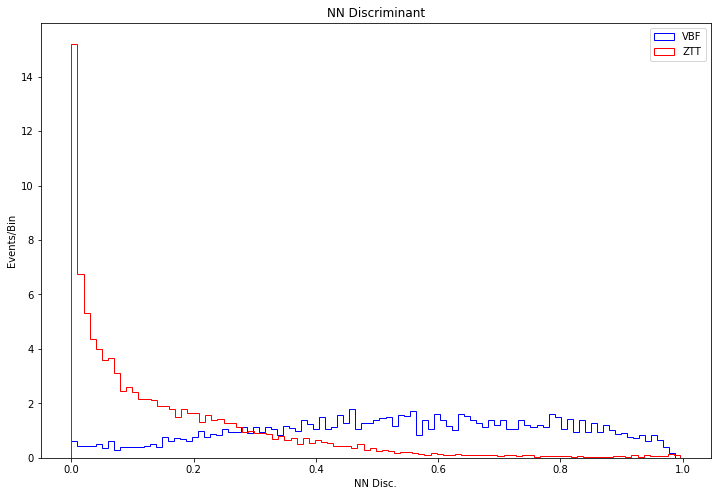

In [15]:
import numpy as np
bigsig = selected_events[(selected_events['isSignal'] == 1)]
sig = bigsig[
    ['Q2V1', 'Q2V2', 'Phi', 'Phi1', 'costheta1', 'costheta2', 'costhetastar', 'isSignal', 'evtwt']
]
bigbkg = selected_events[(selected_events['isSignal'] == 0)]
bkg = bigbkg[
    ['Q2V1', 'Q2V2', 'Phi', 'Phi1', 'costheta1', 'costheta2', 'costhetastar', 'isSignal', 'evtwt']
]

sig_pred = model.predict(sig.values[:,:7])
bkg_pred = model.predict(bkg.values[:,:7])
plt.figure(figsize=(12, 8))
plt.title('NN Discriminant')
plt.xlabel('NN Disc.')
plt.ylabel('Events/Bin')
plt.hist(sig_pred, histtype='step', color='blue', label='VBF', bins=100, density=True)
plt.hist(bkg_pred, histtype='step', color='red', label='ZTT', bins=100, density=True)
plt.legend()

Text(0,0.5,'acc')

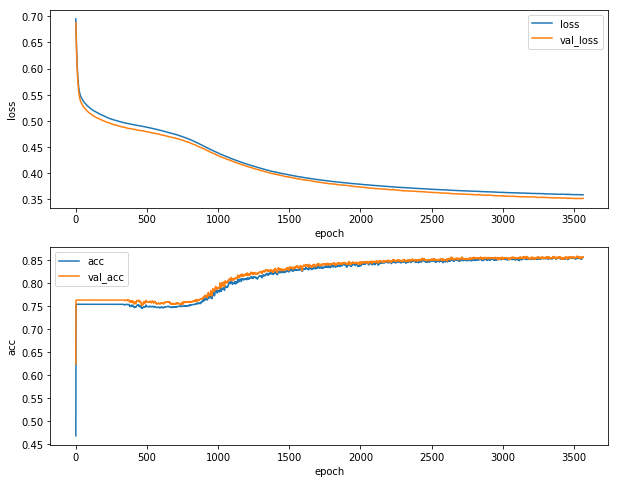

In [16]:
import matplotlib.pyplot as plt
# plot loss vs epoch
plt.figure(figsize=(10,8))
ax = plt.subplot(2, 1, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 1, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

/Users/tmitchel/Documents/higgsToTauTau/NNClassifiers/pyenv/lib/python2.7/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


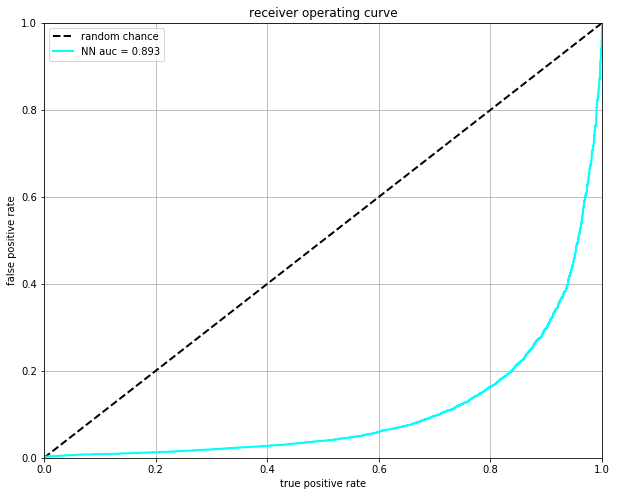

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,8))
# use the model to do classifications
label_predict = model.model.predict(np.concatenate((sig.values[:,:7], bkg.values[:,:7])))
fpr, tpr, _ = roc_curve(
    np.concatenate((sig.values[:,-2], bkg.values[:,-2])), label_predict[:, 0])  # calculate the ROC curve
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
         color='k', label='random chance')
plt.plot(tpr, fpr, lw=2, color='cyan', label='NN auc = %.3f' % (roc_auc))
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.title('receiver operating curve')
plt.legend(loc="upper left")
plt.grid()


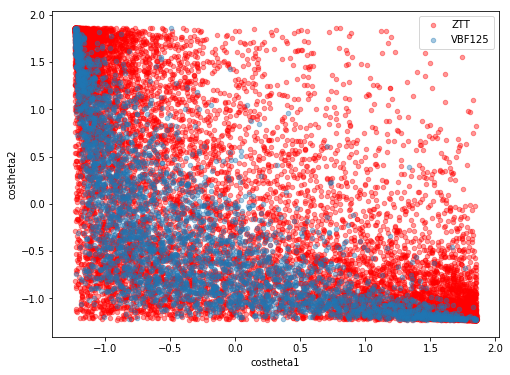

In [18]:
fig, a = plt.subplots()
groups = selected_events.groupby('sample_names')
groups.get_group('ZTT.root').plot.scatter(
    'costheta1', 'costheta2', ax=a, color='r', marker='o', alpha=0.4, label = 'ZTT'
)
groups.get_group('VBF125.root').plot.scatter(
    'costheta1', 'costheta2', ax=a, alpha=0.4, marker='o', figsize=(8,6), label='VBF125'
)

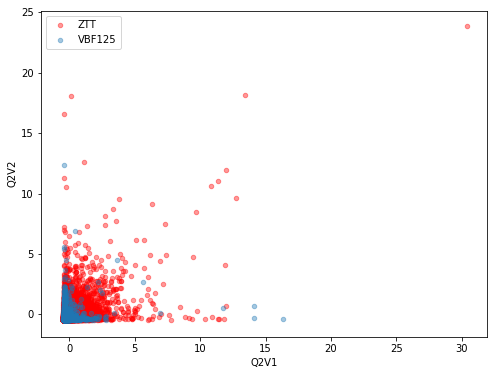

In [19]:
fig, a = plt.subplots()
groups = selected_events.groupby('sample_names')
groups.get_group('ZTT.root').plot.scatter(
    'Q2V1', 'Q2V2', ax=a, color='r', marker='o', alpha=0.4, label = 'ZTT'
)
groups.get_group('VBF125.root').plot.scatter(
    'Q2V1', 'Q2V2', ax=a, alpha=0.4, marker='o', figsize=(8,6), label='VBF125'
)

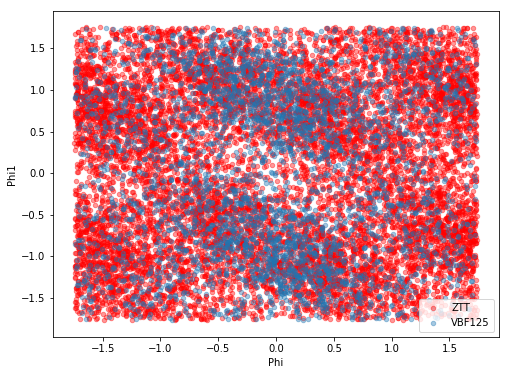

In [20]:
fig, a = plt.subplots()
groups = selected_events.groupby('sample_names')
groups.get_group('ZTT.root').plot.scatter(
    'Phi', 'Phi1', ax=a, color='r', marker='o', alpha=0.4, label = 'ZTT'
)
groups.get_group('VBF125.root').plot.scatter(
    'Phi', 'Phi1', ax=a, alpha=0.4, marker='o', figsize=(8,6), label='VBF125'
)